## 导入相关的包

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from statsmodels.graphics.api import qqplot
import datetime
from pylab import rcParams

from matplotlib.pyplot import MultipleLocator
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

import warnings
import sys
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

warnings.filterwarnings("ignore")

rcParams['figure.figsize']=18,10

## 主程序
**注意**：
+ 导入的数据按月份的需要每个月份中间不能断，按年份的年份不能断

In [2]:
class timeseries():
    def __init__(self,root_path):
        self.month = ["2016-1","2016-2","2016-3","2016-4","2016-5","2016-6","2016-7","2016-8","2016-9","2016-10",
                      "2016-11","2016-12","2017-1","2017-2","2017-3","2017-4","2017-5","2017-6","2017-7","2017-8",
                      "2017-9","2017-10","2017-11","2017-12","2018-1","2018-2","2018-3","2018-4","2018-5","2018-6",
                      "2018-7","2018-8","2018-9","2018-10","2018-11","2018-12","2019-1","2019-2","2019-3","2019-4",
                      "2019-5","2019-6","2019-7","2019-8","2019-9","2019-10","2019-11","2019-12","2020-1","2020-2",
                      "2020-3","2020-4","2020-5","2020-6","2020-7","2020-8","2020-9","2020-10","2020-11","2020-12",
                      "2021-1","2021-2","2021-3","2021-4","2021-5","2021-6"]
        self.province_series_dict = {}  # 省份：省份所有的历史数据
        self.province_dict = {} # 省份：[需要时间段的数据，pqd组合]
        self.root = root_path
    
    def get_data(self,file_path,index_col,preprocessing_list):
        """
        读取工业增加值.xlsx 并且选取出要处理的省份的数据和要处理的时间段的数据
        """
        self.ts = pd.read_excel(file_path,sheet_name='18-20',index_col=index_col)
        self.ts.index = pd.to_datetime(self.ts.index)
        
        # 生成图片并且保存到与程序同一目录的位置
#         self.ts[preprocessing_list].plot(figsize=(20,12))
#         ax = plt.axes()
#         ax.set_facecolor("#06307a")  # 设定图片导出时的路径
#         plt.savefig('./31省工业增加值.png')  #
#         plt.show()
        
        # 选出要保存的省份的数据
        for province in preprocessing_list:
            province_series = self.ts[province]
            province_series.index = pd.DatetimeIndex(province_series.index.values,
                                                     freq=province_series.index.inferred_freq)
            self.province_series_dict [province] = province_series

        
    def preprocessing(self,end_month, interval, predict_interval):
        """
        提取出需要用于回归的时段数据，并且根据AIC值对pqd组合进行排序
        """
        # 将时间转化为索引，根据索引提取出需要的数据
        self.end_index = self.month.index(end_month)
        self.interval = interval
        self.predict_interval = predict_interval
        
        for province in self.province_series_dict:
            series = self.province_series_dict[province]
            # 截取需要的时间段数据
            start.index = max(self.end_index-interval+1,0)
            series = series[pd.to_datetime(self.month[start.index]):pd.to_datetime(self.month[self.end_index+1])]
            print(province)
            # 计算pqd组合
            self.province_dict[province] = [series, self.get_pq(series)]
        return
    
    
    def get_all_predict(self):
        """
        对所有的输入省份的进行预测并且写入结果
        """
        # 写入预测标题
        with open(self.root+'\\预测标题.txt','a') as t:
            t.write("\n%s.%s:\n"%(self.month[self.end_index][0:4],self.month[self.end_index][5:]))
        # 写入预测结果
        for province in self.province_dict:
            predict, conf = self.get_predict(province)
            self.write_txt(province,predict, conf)
        return 
        
    def get_predict(self,province):
        """
        对数据进行预测
        """
        # 判断预测趋势与历史数据是否一致，依次判断pqd的组合是否满足这一要求
        for pqd in self.province_dict[province][1]:
            predict,conf,arma_model,forecast = self.get_model(province,pqd)
            history_trend = (self.province_dict[province][0]-self.province_dict[province][0].shift(1))[-3:]
            predict_trend = (predict-predict.shift(1))[1:3] # 需要判断的预测趋势的范围
            
            # 对历史涨跌幅进行加权求和计算趋势
            history_trend[0] = history_trend[0]*self.weights[0]
            history_trend[1] = history_trend[1]*self.weights[1]
            history_trend[2] = history_trend[2]*self.weights[2]
            
            # 判断预测的趋势是否一直与历史趋势保持一致（此时predict_trend只有两个值，即未来两次的涨跌幅都要和历史总趋势一致
            overall_trend = history_trend.sum()*predict_trend
            if not (overall_trend<0).any():  # 得到趋势一致的pqd组合
                if pqd[1] != 0:
                    print(pqd[1]) # 如果进行过差分，输出是几阶差分的模型
                print(province)
                print(arma_model.summary())
                print('Forecast: %.3f' % forecast)
                print('95%% Confidence Interval: %.2f to %.2f' % (conf[0], conf[1]))
                print(predict)
                
                # 绘图
                fig, ax = plt.subplots(figsize=(30, 4))
                ax = self.province_dict[province][0].plot(ax=ax,label='1月平均',c='red',linewidth=2)    
                ax.yaxis.set_major_locator(MultipleLocator(1)) # 设定y轴的间隔为1

                predict.plot(ax=ax,label='预测值',c='red',linestyle=':',linewidth=2)        
                self.province_dict[province][0].rolling(3).mean().plot(ax=ax,label='3月平均',c='forestgreen')
                ax.legend(loc='upper right')
                plt.show()
                fig.savefig(self.root+'/预测结果/'+self.month[self.end_index]+province+'.png')
                
                # 调整conf的范围，保证输出的置信区间范围在5%以内
                if conf[1]-conf[0]>5:
                    to_shrink = int(((conf[1]-conf[0])-4)/2)
                    conf[1] = conf[1]-to_shrink
                    conf[0] = conf[0]+to_shrink
                return predict,conf
        
    def set_weight(self,weights):
        """
        对于趋势的判断根据权重得出
        分别计算历史数据上个月的涨跌幅，上上个月……共计三次涨跌幅根据这里的权重进行累加和，
        最后的累加值为正则之后的趋势应当为上涨
        """
        self.weights = weights
        
        
    def get_model(self,province,pqd_combination):
        """
        这个函数根据给出的省份进行建模，返回预测值、置信区间、预测模型
        """
        series = self.province_dict[province][0]
        # 建模并且计算置信区间
        arma_model = sm.tsa.ARIMA(series, pqd_combination).fit()
        forecast, stderr, conf = arma_model.forecast()
        
        # 计算指定的时间长度下的预测值
        start = self.month[self.end_index]
        end = self.month[self.end_index+self.predict_interval]        
        predict_y = arma_model.predict(start, end, dynamic=False)
        
        # 如果是1阶差分则计算出的是差分值，实际值需要做累加；2阶差分需要做两次累加
        if pqd_combination[1] == 0:
            predict_y[0] = self.province_dict[province][0][-1]
        elif pqd_combination[1] == 1:
            predict_y[0] = self.province_dict[province][0][-1]
            predict_y = predict_y.cumsum()
        elif pqd_combination[1] == 2:
            predict_y = predict_y.cumsum()
            predict_y[0] = self.province_dict[province][0][-1]
            predict_y = predict_y.cumsum()

        return predict_y, [conf[0][0], conf[0][1]],arma_model,forecast
    
    def data_explore(self):
        """
        对某一段时间的数据进行平稳性检验以及acf、pacf图的绘制
        """
        for province in self.province_dict:
            series = self.province_dict[province][0]
            print(province)
            self.testStationarity(series)
            self.draw_acf_pacf(series, int(len(series) / 2) - 1)
            print("====================================================================")
    
    def testStationarity(self,ts):
        '''
        Unit Root Test
        The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
        root, with the alternative that there is no unit root. That is to say the
        bigger the p-value the more reason we assert that there is a unit root
        '''

        dftest = adfuller(ts)
        # 对上述函数求得的值进行语义描述
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value
        print("平稳性分析：")
        print(dfoutput)
        print("----------------------------------------------------------")
        return dfoutput


    # 自相关和偏相关图，
    def draw_acf_pacf(self,ts, lags=11):
        f = plt.figure(facecolor='white')

        ax1 = f.add_subplot(211)
        fig = plot_acf(ts, lags=lags, ax=ax1)
        ax1.xaxis.set_ticks_position('bottom')
        fig.tight_layout()

        ax2 = f.add_subplot(212)
        fig = plot_pacf(ts, lags=lags, ax=ax2)
        ax2.xaxis.set_ticks_position('bottom')
        fig.tight_layout();
        plt.show()
        print("----------------------------------------------------------")


    def get_pq(self,series, p_max=4, q_max=4, d_max=3):
        df = pd.DataFrame(columns=['combination', 'aic', 'bic', 'hqic'])
        for p in range(p_max):
            for q in range(q_max):
                for d in range(d_max):
                    if p+q+d == 0:
                        continue
                    try:
                        arma_mod = sm.tsa.ARIMA(series, (p, d, q)).fit()
                        #                 print((i,j),arma_mod.aic, arma_mod.bic, arma_mod.hqic)
                        df.loc[len(df) + 1] = [(p, d, q), arma_mod.aic, arma_mod.bic, arma_mod.hqic]
                    except:
                        continue
        df.sort_values(by=['aic'], inplace=True)
        df.reset_index(inplace=True, drop=True)
        print(df)
        print("----------------------------------------------------------")
        
#         if df['combination'][0][0]+df['combination'][0][1]+df['combination'][0][2]==0:
#             return df['combination'][1]
        return df['combination']

    def write_txt(self,province,predict,conf):
        """
        输出文档
        """

        series = self.province_series_dict[province]
        series = series[pd.to_datetime(self.month[self.end_index-self.interval-1]):pd.to_datetime(self.month[self.end_index+1])]
        
        # 输出预测标题
        with open(self.root+'/预测标题.txt','a') as t:
            file_name = "%s:工业增加值下月预测：累计增速%.2f%%~%.2f%%||%s.%s-%s.%s拟合回归预测\n"%(province,conf[0],conf[1],
            self.month[self.end_index-self.interval-2][0:4],self.month[self.end_index-self.interval-2][5:],
            self.month[self.end_index][0:4],self.month[self.end_index][5:])
            t.write(file_name)
            
        # 输出预测结果
        with open(self.root+'/预测结果/'+self.month[self.end_index]+province+'预测.txt', 'w') as f:
            f.write('[\n')
            f.write('\t[\n')
            # 历史数据
            if province == "全国":
                series = self.province_dict[province][0]
                flag = len(series)
                for i,line in enumerate(series):
                    if i+1 == flag:
                        f.write('\t\t[\'%s\',%.1f]\n'%(series.index[i].strftime("%Y.%m"),line))
                    else:
                        f.write('\t\t[\'%s\',%.1f],\n'%(series.index[i].strftime("%Y.%m"),line))
            else:
                flag = len(series)
                for i,line in enumerate(series):
                    if series.index[i].strftime("%m") == '01':
                        continue
                    if i+1 == flag:
                        f.write('\t\t[\'%s\',%.1f]\n'%(series.index[i].strftime("%Y.%m"),line))
                    else:
                        f.write('\t\t[\'%s\',%.1f],\n'%(series.index[i].strftime("%Y.%m"),line))
            f.write('\t],\n')
            
            # 预测数据
            f.write('\t[\n')
            flag = len(predict-1)
            for i,line in enumerate(predict):
                if i+1 == flag:
                    f.write('\t\t[\'%s\',%.1f]\n'%(predict.index[i].strftime("%Y.%m"),line))
                else:
                    f.write('\t\t[\'%s\',%.1f],\n'%(predict.index[i].strftime("%Y.%m"),line))
            f.write('\t],\n')
            
            # 异常原因
            f.write('\t[\n')
            if self.end_index>26 and self.end_index-self.interval<26:
                f.write("\t\t[2018.03,中美贸易战,%.1f],\n"%(self.province_series_dict[province][pd.to_datetime('2018-3-31')]))
                
            if province == "全国":
                if self.end_index>48 and self.end_index-self.interval<48:
                    f.write("\t\t[2020.01,新冠疫情爆发,%.1f],\n"%(self.province_series_dict[province][pd.to_datetime('2020-1-31')]))
                else:
                    pass
            else:
                if self.end_index>48 and self.end_index-self.interval-2<48:
                    f.write("\t\t[2020.01,新冠疫情爆发,%.1f],\n"%(self.province_series_dict[province][pd.to_datetime('2020-2-29')]))
                else:
                    pass
            f.write('\t]\n')

            f.write(']')
            print("文档已输出")

## 获得参数

请输入要预测的省份名称（用，隔开）: 全国，北京
请输入各个历史时期差分值的权重（用，隔开）： 1，2，3
请输入要预测的月份（例：2019-1，用，隔开）： 2019-2，2019-3
请输入要前向判断的时间长度（请输入数字）： 22
请输入要预测的时间长度（请输入数字）： 4


全国
   combination        aic        bic       hqic
0    (1, 1, 0)  17.960065  21.093633  18.640130
1    (2, 1, 0)  18.410355  22.588445  19.317107
2    (1, 1, 1)  18.617667  22.795757  19.524419
3    (0, 1, 1)  18.645525  21.779092  19.325589
4    (0, 1, 2)  18.874401  23.052490  19.781153
5    (0, 1, 3)  20.126105  25.348717  21.259546
6    (1, 1, 2)  20.379387  25.601999  21.512827
7    (2, 0, 0)  20.391545  24.755715  21.419612
8    (3, 1, 0)  20.398836  25.621448  21.532276
9    (2, 1, 1)  20.402064  25.624676  21.535504
10   (0, 2, 2)  21.112131  25.095060  21.889641
11   (1, 0, 2)  21.136632  26.591845  22.421716
12   (3, 0, 0)  21.736594  27.191806  23.021678
13   (0, 0, 2)  21.825742  26.189912  22.853809
14   (2, 1, 2)  22.318248  28.585383  23.678377
15   (1, 0, 1)  22.342610  26.706780  23.370677
16   (3, 1, 1)  22.355321  28.622455  23.715449
17   (1, 2, 2)  22.664091  27.642753  23.635978
18   (0, 2, 3)  22.744905  27.723566  23.716792
19   (1, 0, 0)  22.873290  26.146417 

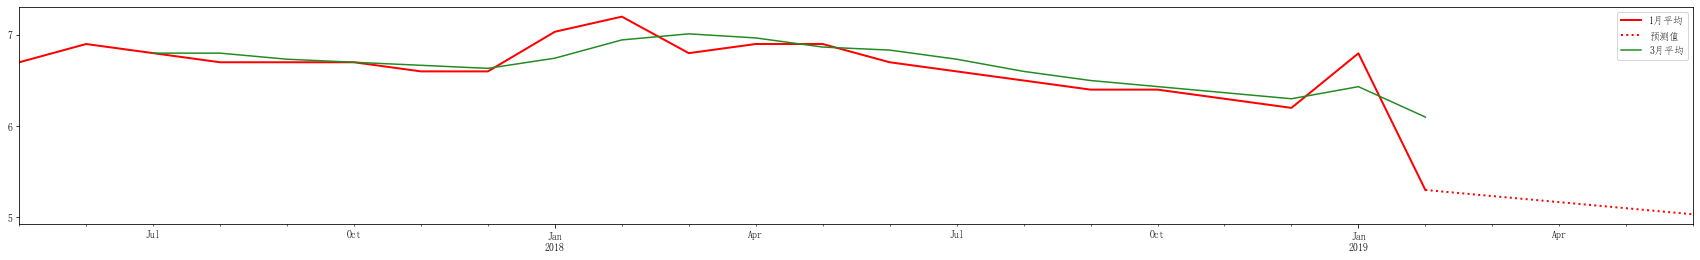

文档已输出
1
北京
                             ARIMA Model Results                              
Dep. Variable:                   D.北京   No. Observations:                   21
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -26.953
Method:                           css   S.D. of innovations              0.873
Date:                Thu, 17 Dec 2020   AIC                             57.906
Time:                        15:33:12   BIC                             59.995
Sample:                    06-30-2017   HQIC                            58.360
                         - 02-28-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0571      0.191     -0.300      0.764      -0.431       0.316
Forecast: 4.243
95% Confidence Interval: 2.53 to 5.95
2019-02-28    4.300000
2019-03-31    4.242857
2019-04-30    4.1857

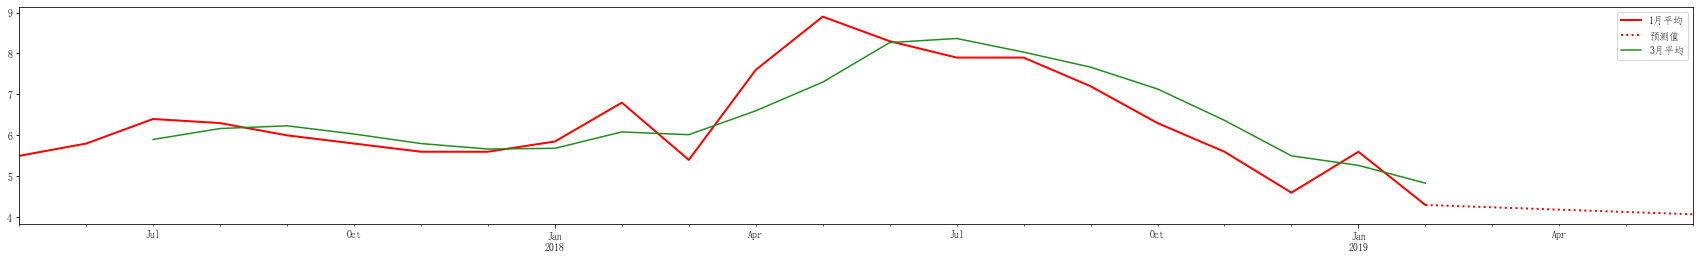

文档已输出
全国
   combination        aic        bic       hqic
0    (1, 1, 0)  17.581178  20.714746  18.261243
1    (2, 1, 0)  18.151442  22.329532  19.058195
2    (1, 1, 1)  18.333224  22.511314  19.239977
3    (0, 1, 2)  18.746538  22.924628  19.653290
4    (0, 1, 1)  19.627164  22.760731  20.307228
5    (1, 1, 2)  20.091471  25.314083  21.224912
6    (3, 1, 0)  20.143005  25.365617  21.276446
7    (2, 1, 1)  20.145325  25.367937  21.278766
8    (0, 1, 3)  20.175349  25.397961  21.308789
9    (1, 1, 3)  20.484212  26.751347  21.844341
10   (2, 0, 0)  20.527831  24.892001  21.555898
11   (1, 0, 2)  21.210445  26.665658  22.495529
12   (3, 0, 0)  21.877532  27.332744  23.162616
13   (2, 1, 2)  22.044822  28.311956  23.404950
14   (2, 0, 1)  22.119942  27.575154  23.405026
15   (3, 1, 1)  22.131513  28.398647  23.491641
16   (2, 0, 2)  22.615665  29.161920  24.157766
17   (0, 0, 2)  23.134678  27.498848  24.162745
18   (2, 1, 3)  23.255609  30.567266  24.842426
19   (1, 2, 1)  23.287854  27.2

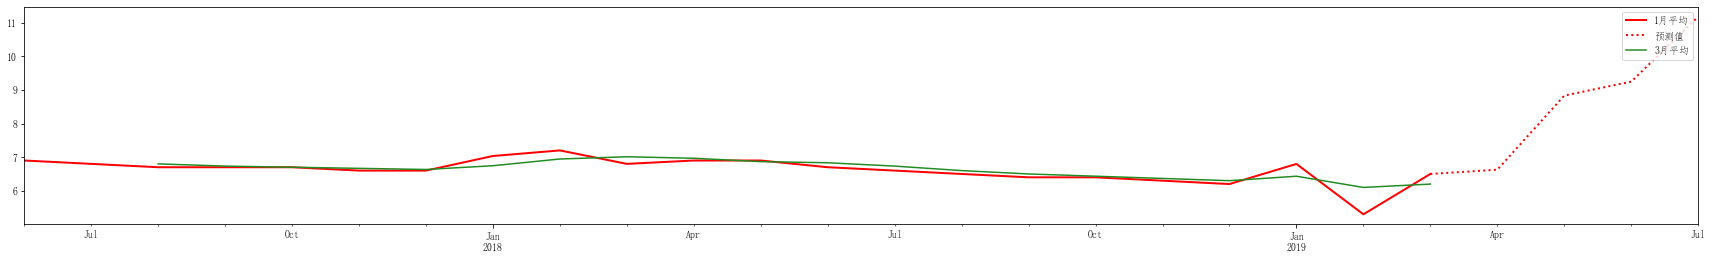

文档已输出
1
北京
                             ARIMA Model Results                              
Dep. Variable:                   D.北京   No. Observations:                   21
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -33.094
Method:                           css   S.D. of innovations              1.170
Date:                Thu, 17 Dec 2020   AIC                             70.188
Time:                        15:33:31   BIC                             72.277
Sample:                    07-31-2017   HQIC                            70.642
                         - 03-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1000      0.255      0.392      0.695      -0.400       0.600
Forecast: 8.000
95% Confidence Interval: 5.71 to 10.29
2019-03-31    7.9
2019-04-30    8.0
2019-05-31    8.1
2019-06-30 

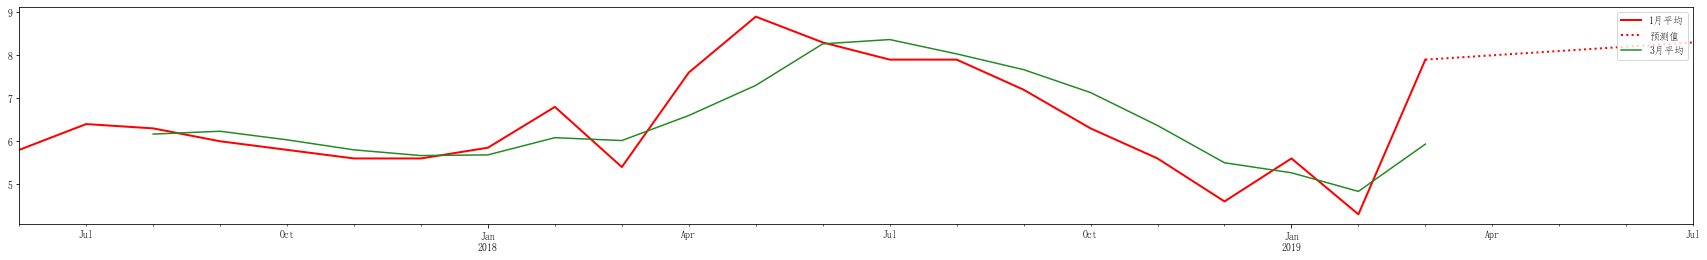

文档已输出


In [10]:
pre_list = input("请输入要预测的省份名称（用，隔开）:")
pre_list = pre_list.split('，')
weights = input("请输入各个历史时期差分值的权重（用，隔开）：")
weights = [int(_) for _ in weights.split('，')]

root_path = os.getcwd()
file_path = root_path+"\\工业增加值 时间序列预测.xls"
index_col = 'month'

T = timeseries(root_path)
T.get_data(file_path=file_path, index_col=index_col, preprocessing_list=pre_list)
T.set_weight(weights)

predict_series = input("请输入要预测的月份（例：2019-1，用，隔开）：")
interval = input("请输入历史的时间长度（请输入数字）：")
to_predict_interval = input("请输入要预测的时间长度（请输入数字）：")

for to_p in predict_series.split('，'):
    T.preprocessing(to_p,int(interval),int(to_predict_interval))
    T.get_all_predict()

In [ ]:
全国，北京
1，2，3
2019-2，2019-3